Topic Mapping: {0: 'World', 1: 'Sport', 2: 'Business', 3: 'Sci/Tech'}
Training Data Preview:
                                                text  label
0  wall st bears claw back black reuters reuters ...      2
1  carlyle looks toward commercial aerospace reut...      2
2  oil economy cloud stocks outlook reuters reute...      2
3  iraq halts oil exports main southern pipeline ...      2
4  oil prices soar alltime record posing new mena...      2
Training the model...
Epoch 1/10


C:\Users\Neutral\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4304 - loss: 2.7341 - val_accuracy: 0.8319 - val_loss: 1.3425 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8372 - loss: 0.6910 - val_accuracy: 0.8794 - val_loss: 0.6353 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8700 - loss: 0.4487 - val_accuracy: 0.8842 - val_loss: 0.3951 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8819 - loss: 0.3892 - val_accuracy: 0.8880 - val_loss: 0.3619 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8898 - loss: 0.3552 - val_accuracy: 0.8785 - val_loss: 0.3781 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8964 - loss: 0.3364 - val_accuracy: 0.8796 - val_loss: 0.3682 - learning_rate: 0.0010
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9051 - loss: 0.3117 - val_

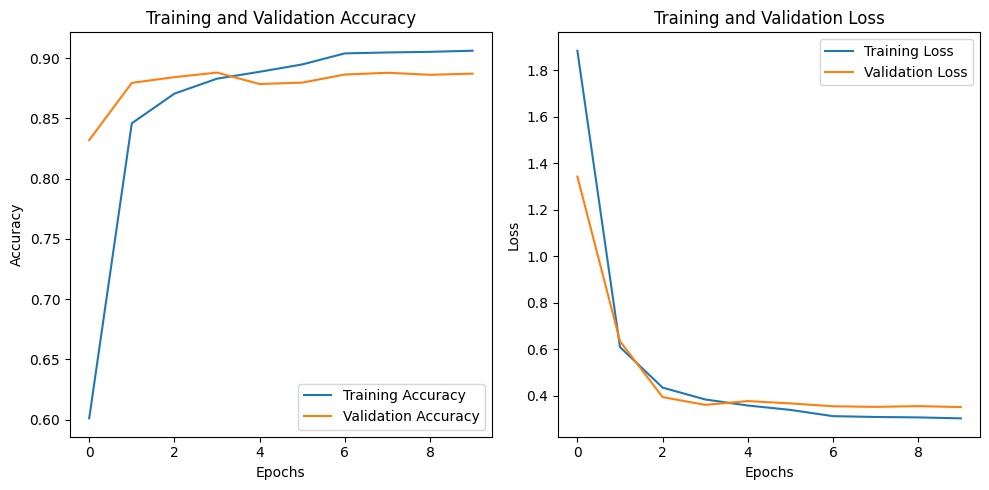

Test Data Preview:
                                                text  label
0  three quarters financial firms still conductin...      2
1  european stocks rally hope ecb may done intere...      2
2  gold prices hit new high value bitcoin also su...      2
3              food discount stickers may thing past      2
4  german cabinet tries solve ‘ nodebt ’ crisis c...      2
Fixed Test Data Columns:
                                                text  label
0                                               text  label
1  three quarters financial firms still conductin...      2
2  european stocks rally hope ecb may done intere...      2
3  gold prices hit new high value bitcoin also su...      2
4              food discount stickers may thing past      2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Predictions saved to test_data_with_predictions.csv.
                                                text  label predicted_topic
0                                               text  label        B

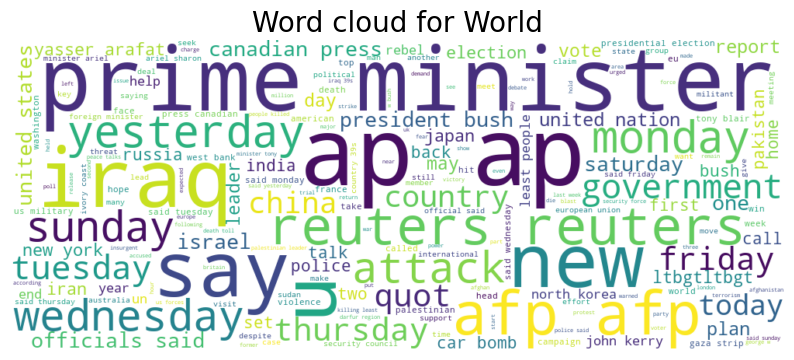

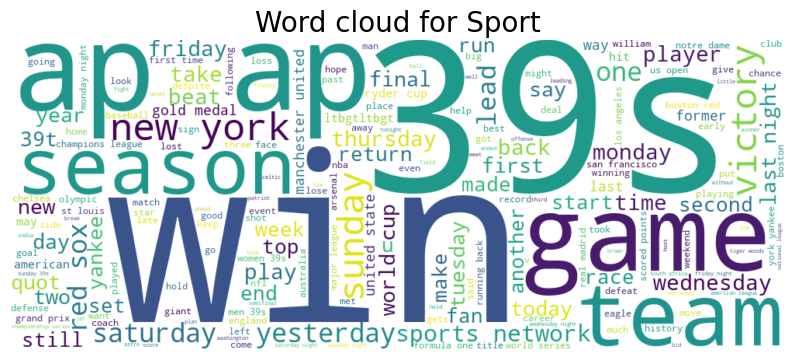

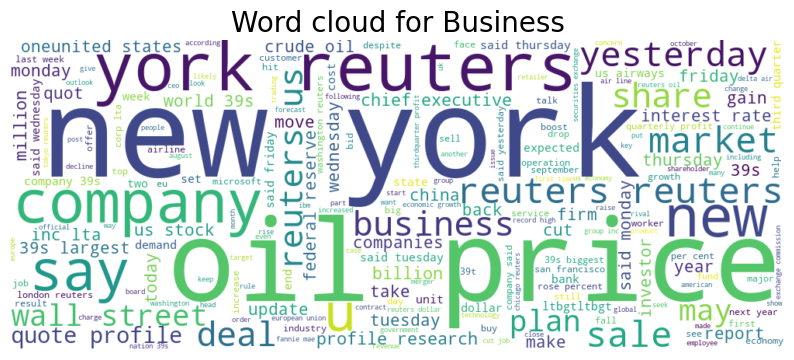

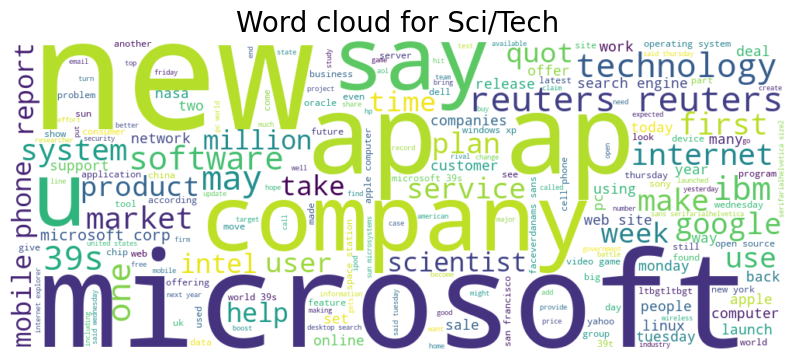

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout, LSTM, Bidirectional, BatchNormalization, GlobalMaxPooling1D, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Step 1: Load the Training Dataset
train_file_path = "cleaned_training_data.csv"  
df_train = pd.read_csv(train_file_path, skiprows=1)

# Topic Mapping
topic_mapping = {0: "World", 1: "Sport", 2: "Business", 3: "Sci/Tech"}
print("Topic Mapping:", topic_mapping)

# Check Training Dataset
print("Training Data Preview:")
print(df_train.head())

# Extract inputs and labels for training
X_train_text = df_train['text'].astype(str) 
y_train_labels = df_train['label'].values   

# Step 3: Preprocess Training Text Data
vocab_size = 10000  
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

# Convert headlines into padded sequences
max_length = 15  
X_train_sequences = tokenizer.texts_to_sequences(X_train_text)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train_labels, num_classes=4)

# Step 4: Train-Test Split for Validation
X_train, X_val, y_train_split, y_val_split = train_test_split(
    X_train_padded, y_train, test_size=0.2, random_state=42
)

# Step 5: Improved Model Definition
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),  
    GaussianNoise(0.1),
    Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01))),  
    GlobalMaxPooling1D(),  
    BatchNormalization(),  
    Dropout(0.5),  
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)

# Step 6: Train the Model
print("Training the model...")
history = model.fit(
    X_train, y_train_split,
    epochs=10,  
    batch_size=512,
    validation_data=(X_val, y_val_split),
    callbacks=[early_stop, reduce_lr]
)

# Step 7: Evaluate the Model
loss, accuracy = model.evaluate(X_val, y_val_split)
print(f"Validation Accuracy: {accuracy:.2f}")

# Step 8: Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(10, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 9: Load the Test Dataset
test_file_path = "cleaned_test_data.csv"  
df_test = pd.read_csv(test_file_path)

print("Test Data Preview:")
print(df_test.head())

# Reload the test dataset, forcing no header
df_test = pd.read_csv("cleaned_test_data.csv", header=None)

# Rename columns properly
df_test.columns = ['text', 'label'] 

print("Fixed Test Data Columns:")
print(df_test.head())

# Preprocess Test Data
X_test_text = df_test['text'].astype(str)  # Now this will work
X_test_sequences = tokenizer.texts_to_sequences(X_test_text)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

# Step 10: Predict Topics on Test Data
predictions = np.argmax(model.predict(X_test_padded), axis=-1)

# Map Predictions to Topic Names
predicted_topics = [topic_mapping[pred] for pred in predictions]

# Add Predictions to the Test DataFrame
df_test['predicted_topic'] = predicted_topics

# Save Predictions to a CSV File
output_file_path = "test_data_with_predictions.csv"
df_test.to_csv(output_file_path, index=False)

print(f"Predictions saved to {output_file_path}.")
print(df_test.head())

# Function to generate and display word cloud for a given text
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=999, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Generate word clouds for each topic category in the training dataset
for topic_id, topic_name in topic_mapping.items():
    topic_text = ' '.join(df_train[df_train['label'] == topic_id]['text'].astype(str))
    generate_wordcloud(topic_text, f"Word cloud for {topic_name}")


In [12]:
# Step 11: Predict Topic for a New Headline
def predict_topic(headline):
    # Preprocess the input text
    input_sequence = tokenizer.texts_to_sequences([headline])
    input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')

    # Predict the topic
    prediction = np.argmax(model.predict(input_padded), axis=-1)
    predicted_topic = topic_mapping[prediction[0]]

    return predicted_topic

# Example of predicting a topic for a new headline
headline_input = input("Enter a headline: ")
predicted_topic = predict_topic(headline_input)
print(f"Predicted Topic for the headline: {predicted_topic}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Predicted Topic for the headline: Sport


: 